# **FEATURE EXTRACTION USING TFIDF**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from gensim.models import Word2Vec
from textblob import TextBlob
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from scipy.sparse import save_npz, load_npz


In [2]:
#set seed so that code output is deterministic
random.seed(20)  # Set the seed for Python's random module
np.random.seed(20)  # Set the seed for NumPy's random module

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/filtered_corpus.csv', converters ={'tokens':list_converter,
                                                           'updated_tokens': list_converter})

In [4]:
# Count the number of rows where the length of 'tokens' is less than 3
count = data[data['updated_tokens'].apply(lambda x: len(x) < 3)].shape[0]
indx = data[data['updated_tokens'].apply(lambda x: len(x) < 3)].index
print(f"Number of rows with less than 3 tokens: {count}")
print (indx[:5])

Number of rows with less than 3 tokens: 24832
Index([0, 4, 5, 6, 7], dtype='int64')


In [5]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

(95028, 8)


,text_type,ID,year,long_text,clean_text,word_count,tokens,updated_tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]",[road]
1,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]","[single, travel, past]"
2,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]","[shop, dragon, mart]"
3,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]","[hilarious, spring, souk]"
4,comment,gtfw6yj,2021,Eugene's first day as a signwriter for Country...,eugene s day signwriter country artificial pro...,8,"[eugene, s, day, signwriter, country, artifici...","[artificial, product]"


In [51]:
#drop rows with less than 3 tokens
data = data.drop(indx, axis = 0).reset_index()

In [80]:
data.shape

(70196, 9)

## **TFIDF MODEL**

In [52]:
#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['updated_tokens'].apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

['single travel past',
 'shop dragon mart',
 'hilarious spring souk',
 'reel cinema roxy emaar',
 'innocent pls explain everyday']

#### **INSTANTIATE AND FIT TFIDF MODEL**

In [73]:
#custom stop words

stop_words = list(set(["remove", "near", "take", "call", "read", "low", "learn", "small",
                "base", "course", "expensive", "break", "support", "human", "remove",
                "level", "enjoy", "compare", "complain", "state", "stand", "provide",
                 "system", "notice", "type", "clearly", "stupid", "avoid", "owner",
                 "emirate", "emirates", "axplain", "early", "grow", "chance", "funny",
                 "beautiful", "stick", "choose", "source", "part", "decide", "black", "require",
                 "completely", "personal", "available", "huge", "later", "hell", "medium", "suppose",
                 "plus", "clear", "receive", "slow", "suggest", "return", "welcome", "step", "actual",
                 "realize", "choice", "recommend", "increase", "awesome", "sort", "throw", "obviously",
                 "datum", "prefer", "short", "yesterday", "history","today", "tomorrow", "next", "average",
                 "kill", "relate", "perfect", "content", "suck", "random", "response", "finally", "original",
                 "multiple", "multiply", "gulf", "hopefully", "push", "reality", "ahead", "page", "instagram",
                 "confirm", "specific", "strong", "name", "figure", "fill", "cause", "main", "basic","touch",
                 "willing", "prove", "lead", "forward", "truly", "carry", "put", "plenty", "reduce", "hello",
                 "major", "statement", "proof", "involve", "affect", "access", "regardless", "abu", "abu dhabi",
                      "sharjah", "sharjhah", "abu dabhi", "dhabi", "recommendation", "english", "report", "business"]
))              

In [75]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
tfidf = TfidfVectorizer(#max_features = 500,
                        #max_features = 5000,
                        max_df = 0.80,
                        min_df = 5,
                        stop_words = stop_words,
                        ngram_range = (1,2))
   
#generate document vectors 
X_tfidf = tfidf.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The tfidf representation had {X_tfidf.shape[1]} features.")    

The program took 2.20 seconds to complete. The tfidf representation had 14898 features.


In [79]:
#save tfidf vectors & vectorizer
import pickle

with open('pretrained_models/tfidf/tfidf_filtered_vectors.pkl', 'wb') as file:
    pickle.dump(X_tfidf, file)
    

with open('pretrained_models/tfidf/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)
    


In [76]:
#get feature names 
tfidf_features = tfidf.get_feature_names_out()

In [11]:
#print(sorted(tfidf_features))

In [58]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
tfidf_df = pd.DataFrame(X_tfidf[8000:8005].toarray(), columns = tfidf_features)

text_tfidf = tfidf_df.copy()
text_tfidf = text_tfidf.loc[:, (text_tfidf > 0.0).any()] #show only columns with at least a 1 entry for any word

text_tfidf.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_tfidf

,clean_text,bubble,canada,chicken,cost,develop,driving,dxb,employee,factor,...,reasonable price,singapore,tip,toronto,total,total cost,travel,umm,wage,worst
0,ok come jerk chicken dubai toronto pandemic pr...,0.000000,0.000000,0.219996,0.176966,0.000000,0.234816,0.000000,0.0,0.238369,...,0.329073,0.000000,0.000000,0.296892,0.232425,0.337086,0.197831,0.00000,0.000000,0.000000
1,lot people depend tips canada pay minimum wage...,0.000000,0.386527,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.353349,0.000000,0.000000,0.000000,0.000000,0.00000,0.389186,0.000000
2,umm infra debatable ngl dxb best cities develo...,0.000000,0.000000,0.000000,0.000000,0.258066,0.000000,0.292386,0.0,0.000000,...,0.000000,0.284126,0.000000,0.000000,0.000000,0.000000,0.000000,0.31378,0.000000,0.000000
3,average salaried employee avoid wht,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,acting privileged living bubble worst kind ign...,0.495629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.496967


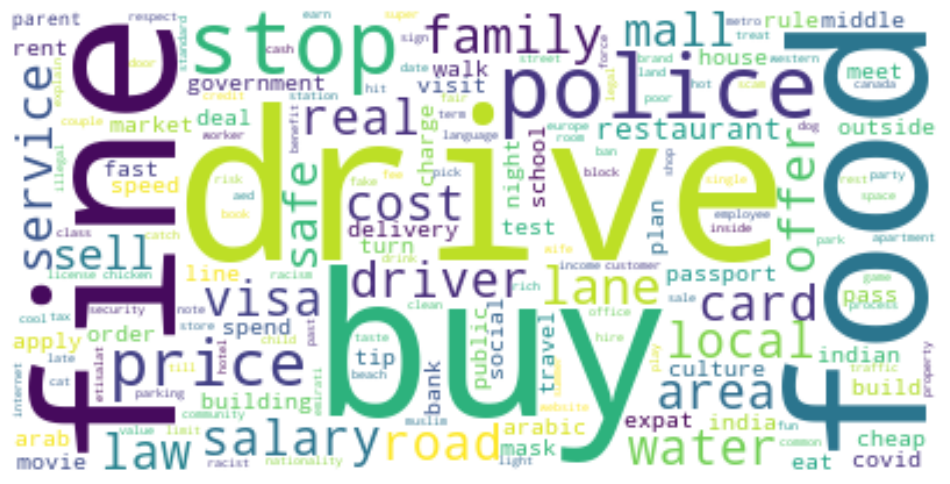

In [77]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(tfidf_features, X_tfidf.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
if 'out' in tfidf_features:
    print ('yes')
else:
    print ('no')

yes


In [78]:
sorted_words = sorted(word_scores_dict.items(), key =lambda x: x[1], reverse = True)

topn_words = sorted_words[:10]

for word,score in topn_words:
    print (f'{word}: {score}')

drive: 466.2406517964624
buy: 419.49684653581835
fine: 383.53998673825697
food: 371.45869564767463
police: 364.3313654388789
stop: 363.8220751884388
price: 361.79520013489145
family: 343.29813816708725
lane: 342.2102475317589
road: 324.4430268361735


In [14]:
#determine optimum k-clusters using yellowbrick visualizer

#i
#kmeans = KMeans(init = 'k-means++', n_init = 10, random_state = 0)
#visualizer = KElbowVisualizer(kmeans, k = (1,21))

#visualizer.fit(X_tfidf.toarray())
#visualizer.show()


In [15]:
#sil_visualizer = SilhouetteVisualizer(
#                    KMeans(n_clusters= 10, #visualizer.elbow_value_, 
#                           init="k-means++", max_iter=300, n_init=10, random_state = 12), 
#                    colors = 'yellowbrick')

#sil_visualizer.fit (X_tfidf)
#sil_visualizer.show()

In [16]:
#true_k = 10 #visualizer.elbow_value_
#
#model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=10, random_state = 10)
#
#model.fit(X_tfidf.toarray())
#
#order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#terms = tfidf_features
#
#i = 0
#for cluster in order_centroids:
#    print (f'cluster {i}')
#    for keyword in cluster[:10]:
#        print (terms[keyword])
#    print ("")
#    i+=1

In [17]:
# Reduce the dimensionality of the document vectors to 2D
#import plotly.express as px
#
#pca = PCA(n_components=2)
#doc_vectors_2d = pca.fit_transform(normalized_fc_doc_vectors)
#docs = data['updated_tokens'].copy()